In [27]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import shap
import pandas as pd
import os
import src.utils as utils
import src.classifier as clf
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from src.preprocess import TextCleaner
from src.preprocess import ColumnSelector
from src.preprocess import TypeSelector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

In [28]:
path = os.getcwd()
labels = pd.read_table(path + '/resources/data/corpus_machismo_etiquetas.csv', sep=";")
labels = labels[["status_id","categoria"]]
tweets_fields = pd.read_csv(path + '/resources/data/corpus_machismo_frodriguez_atributos_extra.csv', 
                            dtype={'status_id': 'str'})
tweets_fields.head()

,filename,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,...,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,termino
0,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,154970429,1013567568039366661,2018-07-01 23:38:34,valunaticx,hoy a la mañana me quisieron levantar a un aut...,Twitter for Android,106,NaN,NaN,...,10537,2010-06-12 18:54:29,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/15497042...,http://abs.twimg.com/images/themes/theme10/bg.gif,http://pbs.twimg.com/profile_images/1010928341...,feminazi
1,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,996795854123134977,1013555580680667136,2018-07-01 22:50:56,MillaZapata,@funesmemoriosa @Leaobutron Lo que pasa es que...,Twitter for Android,86,1.013498e+18,50198488.0,...,1326,2018-05-16 16:53:46,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/99679585...,NaN,http://pbs.twimg.com/profile_images/9967992596...,feminazi
2,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,577431222,1013556044096733184,2018-07-01 22:52:46,beluluque1,Anoche a la salida del boliche dos chicos tira...,Twitter for iPhone,276,NaN,NaN,...,2949,2012-05-11 18:14:59,False,NaN,NaN,en,https://pbs.twimg.com/profile_banners/57743122...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9516401268...,feminazi
3,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,87143378,1013492312205398017,2018-07-01 18:39:31,rubinho_152,@tjcope y va la tonta y pregunta por la prensa...,Twitter Lite,81,NaN,182330628.0,...,6,2009-11-03 08:33:03,False,NaN,NaN,en,NaN,http://abs.twimg.com/images/themes/theme1/bg.png,http://abs.twimg.com/sticky/default_profile_im...,"""a fregar"""
4,corpus/1MW_corpus_machismo_frodriguez_2018-11-...,870191034311069697,1013430666539790336,2018-07-01 14:34:34,killwthlove,"Que no me cuentes tu vida, niñata. https://t.c...",Twitter for Android,34,NaN,NaN,...,1258,2017-06-01 08:11:24,False,NaN,NaN,es,https://pbs.twimg.com/profile_banners/87019103...,NaN,http://pbs.twimg.com/profile_images/1012329454...,ninata


In [29]:
x_cols2 = ['text','source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified', 'categoria']
tweets_fields = utils.change_dtypes(tweets_fields, {'status_id': str})
labels = utils.change_dtypes(labels, {'status_id': str})
tweets_labeled = tweets_fields.merge(labels, on = 'status_id', how = 'inner')
tweets_labeled['respuesta'] = np.where(tweets_labeled['reply_to_status_id'].isnull(), 'no', 'si')
tweets_labeled['respuesta_screen_name'] = np.where(tweets_labeled['reply_to_screen_name'].isnull(), 'no', 'si') 
tweets_labeled['hastag_presence'] = np.where(tweets_labeled['hashtags'].isnull(), 'no', 'si') 
tweets_labeled['url_presence'] = np.where(tweets_labeled['urls_url'].isnull(), 'no', 'si') 
tweets_labeled['mentions_presence'] = np.where(tweets_labeled['mentions_user_id'].isnull(), 'no', 'si') 
dudosos_dict = {"DUDOSO": "MACHISTA"}
#tweets_labeled = tweets_labeled.replace({"categoria" :dudosos_dict})
#tweets_labeled = utils.downsample(tweets_labeled, 'NO_MACHISTA', 267)
#tweets_labeled = utils.downsample(tweets_labeled, 'MACHISTA', 267)
#tweets_labeled = tweets_labeled.loc[80:100,:]
#tweets_labeled = tweets_labeled.loc[0:100,:]
tweets_labeled.head()
categorical_features = ['source', 'respuesta', 'respuesta_screen_name',
          'hastag_presence', 'url_presence',
          'media_type', 'mentions_presence', 'verified']
for f in categorical_features:
    tweets_labeled[f] = tweets_labeled[f].astype("category")

In [30]:
x_cols = ['source', 'display_text_width', 'respuesta', 'respuesta_screen_name',
          'favorite_count', 'retweet_count', 'hastag_presence',
          'url_presence', 'media_type', 'mentions_presence',
          'followers_count', 'friends_count', 'listed_count', 'statuses_count',
          'favourites_count', 'verified']
classifier = 'logistic_regression'
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            SimpleImputer(strategy="constant"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="constant", fill_value = "NA"),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)
        
preprocessor = TextCleaner(filter_users=True, filter_hashtags=True, 
                           filter_urls=True, convert_hastags=True, lowercase=True, 
                           replace_exclamation=True, replace_interrogation=True, 
                           remove_accents=True, remove_punctuation=True, replace_emojis=True)   
     
text_pipeline = Pipeline([
    ('column_selection', ColumnSelector('text')),
    ('tfidf', TfidfVectorizer(tokenizer=utils.tokenizer_, 
                                          smooth_idf=True, preprocessor = preprocessor,
                                          norm=None, min_df=0.01, ngram_range=(1,1)))
])  
    
union_pipeline = Pipeline([('feature-union', FeatureUnion([('text-features', text_pipeline), 
                               ('other-features', preprocess_pipeline)
                              ]))
                          ])

In [31]:

dataset_tfidf = union_pipeline.fit_transform(tweets_labeled[x_cols2]).todense()
numeric = tweets_labeled[x_cols2].select_dtypes(include=np.number).columns.tolist()
categorical = preprocess_pipeline.steps[1][1].transformer_list[1][1].steps[2][1].get_feature_names().tolist()
columns = text_pipeline.named_steps['tfidf'].get_feature_names() + numeric + categorical
df = pd.DataFrame(dataset_tfidf, columns = columns)

In [32]:
df.shape

(3600, 222)

In [33]:
df.to_csv("tfidf.csv")

In [34]:
tweets_labeled[x_cols2].shape

(3600, 18)

In [35]:
df.head()

,2,ahi,ahora,alguien,amiga,anda,ano,aqui,asi,aunqu,...,x3_no,x3_si,x4_no,x4_si,x5_NA,x5_photo,x6_no,x6_si,x7_False,x7_True
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [36]:
from sklearn.model_selection import train_test_split
#num_dict = {"DUDOSO": 3, "MACHISTA": 1, "NO_MACHISTA" : 2}
#tweets_labeled = tweets_labeled.replace({"categoria" :num_dict})
X_train, X_test, y_train, y_test = train_test_split(df, tweets_labeled['categoria'], test_size=0.1, random_state=7)
classifier = clf.get_classifier('random_forest')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
#y_pred


array(['NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'MACHISTA', 'NO_MACHISTA', 'DUDOSO', 'MACHISTA', 'NO_MACHISTA',
       'DUDOSO', 'NO_MACHISTA', 'MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'NO_MACHISTA', 'MACHISTA', 'NO_MACHISTA', 'MACHISTA', 'MACHISTA',
       'DUDOSO', 'NO_MACHISTA', 'MACHISTA', 'NO_MACHISTA', 'MACHISTA',
       'MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'MACHISTA', 'NO_MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA',
       'NO_MACHISTA', 'NO_MACHISTA', 'NO_MACHISTA', 'MACHISTA', 'MACHISTA',
       'NO_MACHISTA'

In [37]:
classifier.classes_

array(['DUDOSO', 'MACHISTA', 'NO_MACHISTA'], dtype=object)

In [38]:
tweets_labeled.iloc[517]['text']

'@Kindnssex @peeserre Y becky g por lo menos no es "tan" machista. Aunque para ser chica le llega'

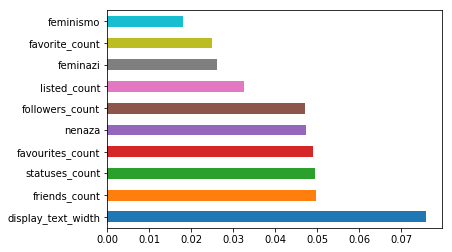

In [80]:
importances = classifier.feature_importances_[1:10]
std = np.std([tree.feature_importances_ for tree in classifier.estimators_[1:10]],
             axis=0)
indices = np.argsort(importances)[::-1]
feat_importances = pd.Series(classifier.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [88]:
#from sklearn.tree import export_graphviz
# Export as dot file
#estimator = classifier.estimators_[5]

#export_graphviz(estimator, out_file='tree.dot', 
#                feature_names = df.columns,
#                class_names = classifier.classes_,
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

In [72]:
X_train.shape[1]

222

In [39]:
explainer = shap.TreeExplainer(classifier)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)
#tweets_labeled['categoria']

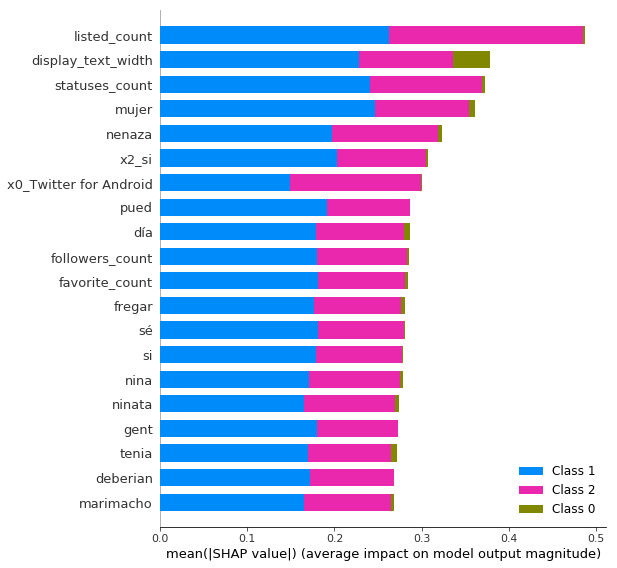

In [40]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


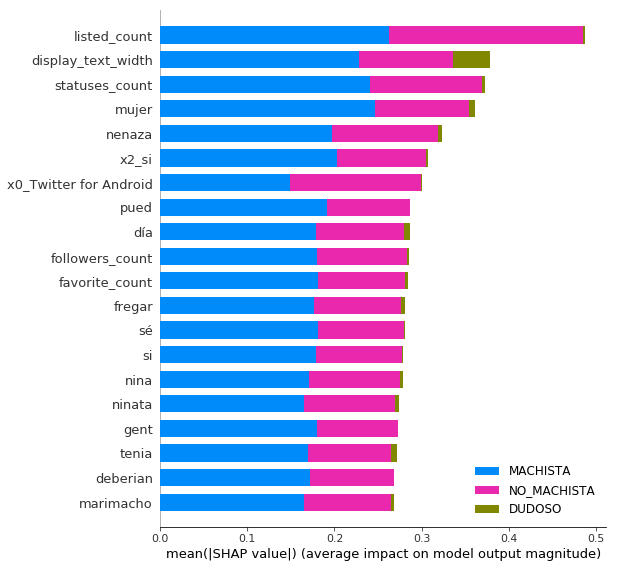

In [47]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names = classifier.classes_)

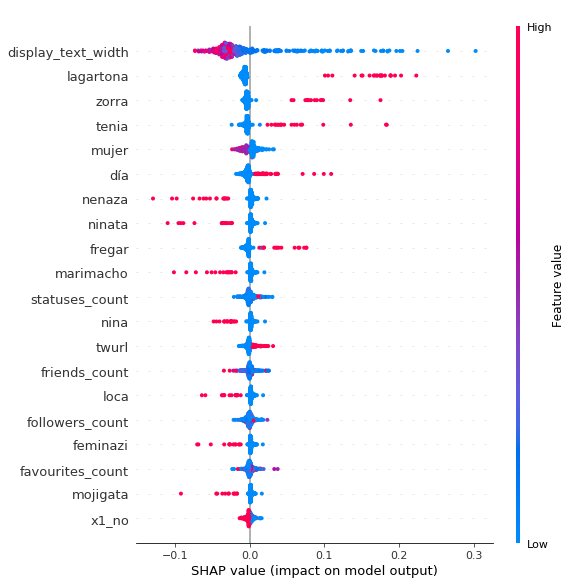

In [42]:
#DUDOSO
shap.summary_plot(shap_values[0], X_test)


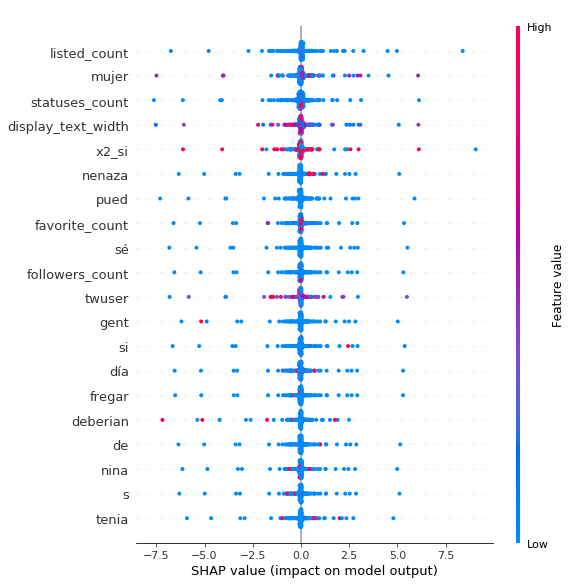

In [52]:
#MACHISTA
shap.summary_plot(shap_values[1], X_test)


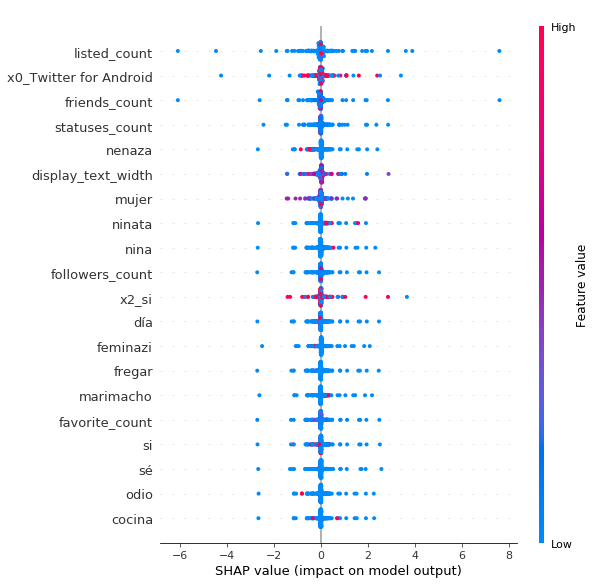

In [53]:
#NO MACHISTA
shap.summary_plot(shap_values[2], X_test)


In [89]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][50,:], X_test.iloc[50,:])


In [44]:
#X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
#model = clf.get_classifier('random_forest')
#model.fit(X_train, Y_train)
#shap_values = shap.TreeExplainer(model).shap_values(X_test)
#shap.summary_plot(shap_values, X_test)

In [45]:
#class_names = model.classes_
#shap.summary_plot(shap_values, X_test, class_names=class_names)

In [46]:
#model.classes_